# Assignment 2: **Machine learning with tree based models** 

In this assignment, you will work on the **Titanic** dataset and use machine learning to create a model that predicts which passengers survived the **Titanic** shipwreck. 

---
## About the dataset:
---
* The column named  `Survived` is the label and the remaining columns are features. 
* The features can be described as given below:
  <table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Definition </th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>pclass</td>
      <td>Ticket class	</td>
    </tr>
    <tr>
      <td>SibSp</td>
      <td>Number of siblings / spouses aboard the Titanic</td>
    </tr>
    <tr>
      <td>Parch</td>
      <td>Number of parents / children aboard the Titanic</td>
    </tr>
    <tr>
      <td>Ticket</td>
      <td>Ticket number</td>
    </tr>
    <tr>
      <td>Embarked</td>
      <td>Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton</td>
    </tr>
  </tbody>
</table> 	

---
## Instructions
---
* Apply suitable data pre-processing techniques, if needed. 
* Implement a few classifiers to create your model and compare the performance metrics by plotting the curves like roc_auc, confusion matrix, etc. 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [2]:
titanic_data = pd.read_csv('titanic.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_data.shape

(891, 12)

In [4]:
print(titanic_data.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [5]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


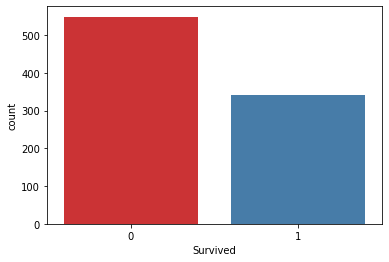

In [6]:
sns.countplot(titanic_data['Survived'], palette='Set1')
plt.show()

In [58]:
X = titanic_data.copy()
X.drop(['PassengerId', 'Cabin', 'Survived', 'Name', 'Ticket'], axis = 1, inplace = True)
y = titanic_data['Survived']
X.head()
X['Embarked'].fillna(X['Embarked'].mode()[0], inplace = True)
X['Age'].fillna(X['Age'].median(), inplace = True)
X['Sex'] = [1 if(i=='male') else 0 for i in X['Sex']]

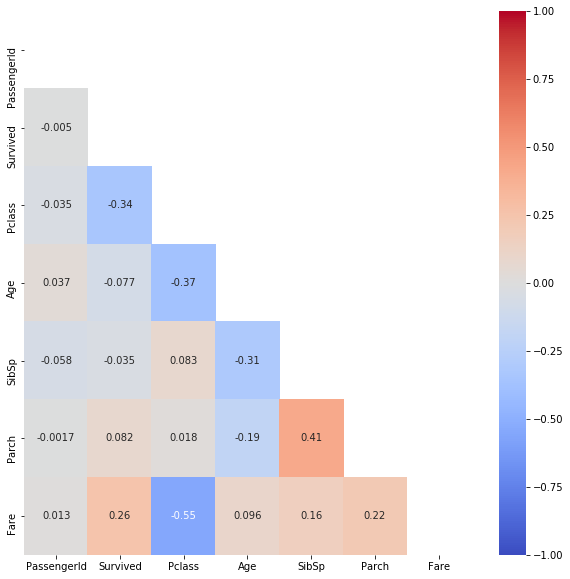

In [59]:
#Seeing the correlation matrix for this data
plt.figure(figsize=(10, 10))
mask = np.zeros_like(titanic_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(titanic_data.corr(), 
            vmin = -1,
            cmap='coolwarm',
            annot=True,
            mask=mask)
plt.savefig('corr-matrix_titanic.png')
plt.show()

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [61]:
X = pd.get_dummies(X)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [63]:
# Instantiate a classification-tree 'dt'
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.16, random_state=0)

# Instantiate a BaggingClassifier 'bc'
bc = BaggingClassifier(base_estimator=dt, n_estimators=300, n_jobs=-1) # n_jobs=-1 means that all the CPU cores are used in computation. 

# Fit 'bc' to the training set
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

# Evaluate and print test-set accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy))

Accuracy of Bagging Classifier: 0.777


In [68]:
rfc = RandomForestClassifier(random_state = 0)
kfold = StratifiedKFold(n_splits = 5)
results = cross_val_score(rfc, X, y, cv=kfold)
results.mean()

0.8215868432615654

In [69]:
parameters = {'max_depth' : range(2, 10, 1), 'n_estimators' : range(50, 250, 40), 'min_samples_split' : range(2, 5, 1)}

grid_search = GridSearchCV(estimator = rfc, param_grid = parameters, scoring = 'accuracy', cv = 10, verbose = True, n_jobs = 10)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    7.6s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   18.6s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   35.7s
[Parallel(n_jobs=10)]: Done 1200 out of 1200 | elapsed:  1.3min finished


({'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 50},
 0.7626564945226917)

In [70]:
new_rfc = grid_search.best_estimator_
new_rfc.fit(X_train, y_train)
preds = new_rfc.predict(X_test)
accuracy_score(y_test, preds)

0.776536312849162